# All model classifications
<p>In this notebook, we will apply all NNs on the tfds Imdb dataset WITH NO SUBWORDS ie. All words will be tokenized fully, no splitting of words into subwords</p>
<p>Models: Flatten, CNN, GRU, LSTM</p>

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/Users/future/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=

### Data preprocessing

In [3]:
training_data = []
training_labels = []
validation_data = []
validation_labels = []

for text, label in imdb['train']:
    training_data.append(text.numpy().decode('utf8'))
    training_labels.append(label.numpy())

for text, label in imdb['test']:
    validation_data.append(text.numpy().decode('utf8'))
    validation_labels.append(label.numpy())

# We don't convert training data to np.array becuase we will encode them ourselves
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)

### Tokenization
Hyperparameters

In [4]:
VOCAB_SIZE = 8192 * 2
OOV_TOK = '<OOV>'
TRUNC_TYPE = 'post'
PAD_TYPE = 'pre'
SNTNC_LEN = 32

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words= VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(training_data)

In [6]:
train_seqs = tokenizer.texts_to_sequences(training_data)
train_pad_seqs = pad_sequences(train_seqs, truncating=TRUNC_TYPE, padding=PAD_TYPE, maxlen=SNTNC_LEN)

val_seqs = tokenizer.texts_to_sequences(validation_data)
val_pad_seqs = pad_sequences(val_seqs, truncating=TRUNC_TYPE, padding=PAD_TYPE, maxlen=SNTNC_LEN)

## Model 1 : Flatten Layer

Hyperparameters

In [7]:
EMBED_DIM = 16
DENSE_NEURONS = 8
EPOCHS = 10
BATCH_SIZE = 256

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

model1 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SNTNC_LEN),
    Flatten(),

    Dense(DENSE_NEURONS, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            262144    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 266257 (1.02 MB)
Trainable params: 266257 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [10]:
hist_data1 = model1.fit(
    train_pad_seqs, 
    training_labels, 
    validation_data=(val_pad_seqs, validation_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10


98/98 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5636 - val_loss: 0.6656 - val_accuracy: 0.6408
Epoch 2/10
98/98 [==============================] - 0s 2ms/step - loss: 0.5630 - accuracy: 0.7431 - val_loss: 0.5390 - val_accuracy: 0.7230
Epoch 3/10
98/98 [==============================] - 0s 2ms/step - loss: 0.3837 - accuracy: 0.8417 - val_loss: 0.5311 - val_accuracy: 0.7320
Epoch 4/10
98/98 [==============================] - 0s 2ms/step - loss: 0.2577 - accuracy: 0.9109 - val_loss: 0.5719 - val_accuracy: 0.7227
Epoch 5/10
98/98 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9570 - val_loss: 0.6295 - val_accuracy: 0.7145
Epoch 6/10
98/98 [==============================] - 0s 2ms/step - loss: 0.0917 - accuracy: 0.9820 - val_loss: 0.6959 - val_accuracy: 0.7068
Epoch 7/10
98/98 [==============================] - 0s 2ms/step - loss: 0.0508 - accuracy: 0.9943 - val_loss: 0.7619 - val_accuracy: 0.7038
Epoch 8/10
98/98 [=============

### Plotting metrics

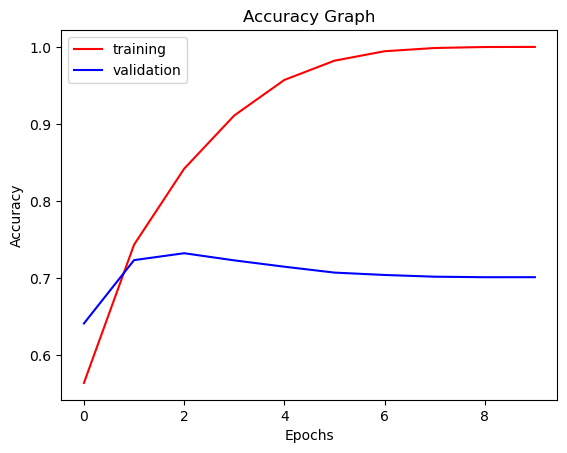

In [11]:
plt.plot(hist_data1.history['accuracy'], 'r', label='training')
plt.plot(hist_data1.history['val_accuracy'], 'b', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

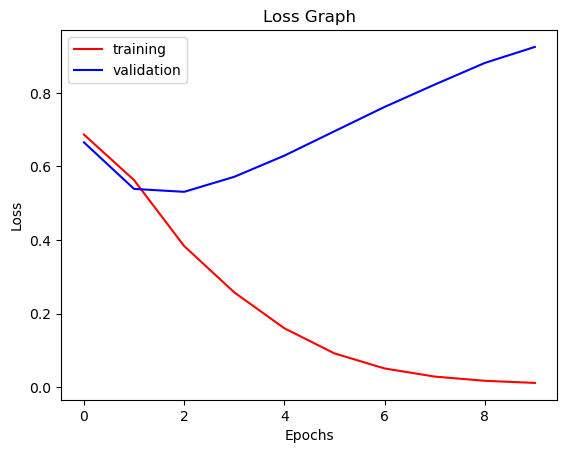

In [12]:
plt.plot(hist_data1.history['loss'], 'r', label='training')
plt.plot(hist_data1.history['val_loss'], 'b', label='validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Model 2 : Bidirectional LSTM

Hyperparameters

In [13]:
EMBED_DIM = 16
BLSTM_UNITS = 16
DENSE_NEURONS = 8
EPOCHS = 10
BATCH_SIZE = 256

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional

model2 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SNTNC_LEN),
    Bidirectional(LSTM(BLSTM_UNITS)),

    Dense(DENSE_NEURONS, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            262144    
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 266641 (1.02 MB)
Trainable params: 266641 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [16]:
hist_data2 = model2.fit(
    train_pad_seqs, 
    training_labels, 
    validation_data=(val_pad_seqs, validation_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10
98/98 [==============================] - 3s 15ms/step - loss: 0.6410 - accuracy: 0.6303 - val_loss: 0.5487 - val_accuracy: 0.7245
Epoch 2/10
98/98 [==============================] - 1s 12ms/step - loss: 0.4475 - accuracy: 0.7937 - val_loss: 0.5393 - val_accuracy: 0.7318
Epoch 3/10
98/98 [==============================] - 1s 11ms/step - loss: 0.3499 - accuracy: 0.8565 - val_loss: 0.6007 - val_accuracy: 0.7156
Epoch 4/10
98/98 [==============================] - 1s 11ms/step - loss: 0.2897 - accuracy: 0.8890 - val_loss: 0.6496 - val_accuracy: 0.7142
Epoch 5/10
98/98 [==============================] - 1s 11ms/step - loss: 0.2362 - accuracy: 0.9156 - val_loss: 0.7358 - val_accuracy: 0.7034
Epoch 6/10
98/98 [==============================] - 1s 11ms/step - loss: 0.1972 - accuracy: 0.9313 - val_loss: 0.8298 - val_accuracy: 0.6970
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 0.1652 - accuracy: 0.9445 - val_loss: 0.9254 - val_accuracy: 0.6920
Epoch 8/10
98

### Plotting metrics

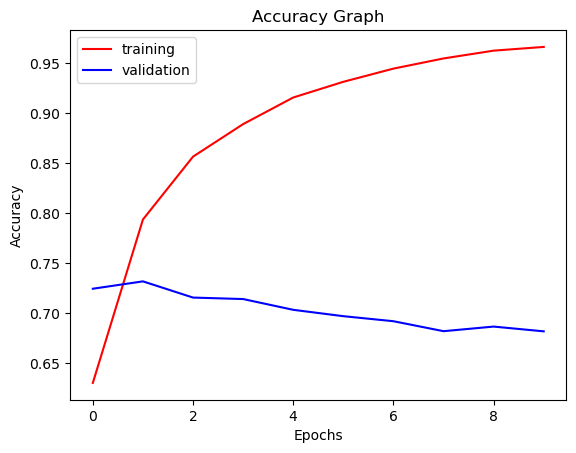

In [17]:
plt.plot(hist_data2.history['accuracy'], 'r', label='training')
plt.plot(hist_data2.history['val_accuracy'], 'b', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

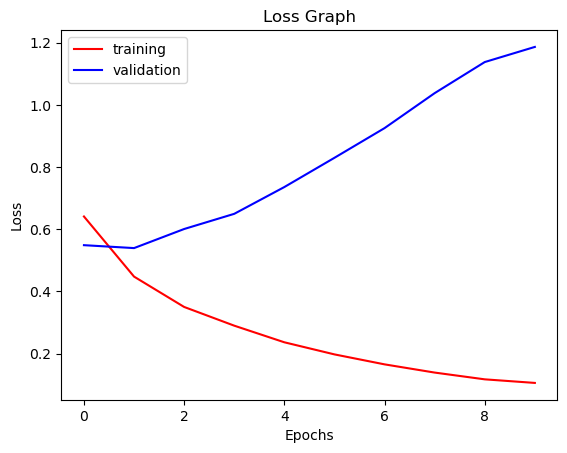

In [18]:
plt.plot(hist_data2.history['loss'], 'r', label='training')
plt.plot(hist_data2.history['val_loss'], 'b', label='validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Model 3: Bidirectional GRU

In [19]:
EMBED_DIM = 16
GRU_UNITS = 16
DENSE_NEURONS = 8
EPOCHS = 10
BATCH_SIZE = 256

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional

model3 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SNTNC_LEN),
    Bidirectional(GRU(GRU_UNITS)),

    Dense(DENSE_NEURONS, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 16)            262144    
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                3264      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 265681 (1.01 MB)
Trainable params: 265681 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [22]:
hist_data3 = model3.fit(
    train_pad_seqs, 
    training_labels, 
    validation_data=(val_pad_seqs, validation_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10
98/98 [==============================] - 3s 14ms/step - loss: 0.6744 - accuracy: 0.5891 - val_loss: 0.5897 - val_accuracy: 0.6840
Epoch 2/10
98/98 [==============================] - 1s 10ms/step - loss: 0.4754 - accuracy: 0.7733 - val_loss: 0.5304 - val_accuracy: 0.7291
Epoch 3/10
98/98 [==============================] - 1s 11ms/step - loss: 0.3589 - accuracy: 0.8453 - val_loss: 0.5542 - val_accuracy: 0.7257
Epoch 4/10
98/98 [==============================] - 1s 11ms/step - loss: 0.2903 - accuracy: 0.8831 - val_loss: 0.6150 - val_accuracy: 0.7164
Epoch 5/10
98/98 [==============================] - 1s 11ms/step - loss: 0.2386 - accuracy: 0.9084 - val_loss: 0.7176 - val_accuracy: 0.7036
Epoch 6/10
98/98 [==============================] - 1s 11ms/step - loss: 0.1922 - accuracy: 0.9304 - val_loss: 0.8013 - val_accuracy: 0.7013
Epoch 7/10
98/98 [==============================] - 1s 11ms/step - loss: 0.1608 - accuracy: 0.9447 - val_loss: 0.9526 - val_accuracy: 0.6848
Epoch 8/10
98

### Plotting metrics

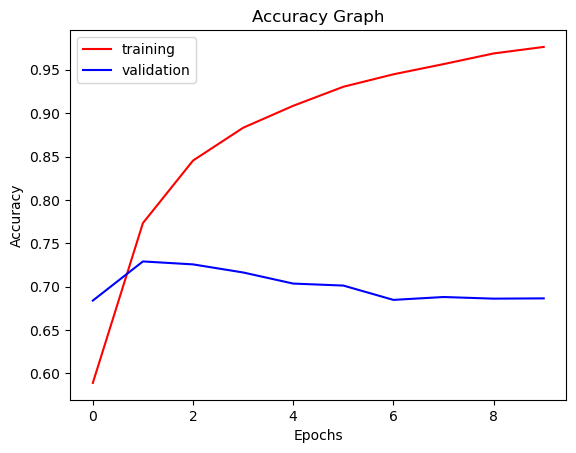

In [23]:
plt.plot(hist_data3.history['accuracy'], 'r', label='training')
plt.plot(hist_data3.history['val_accuracy'], 'b', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

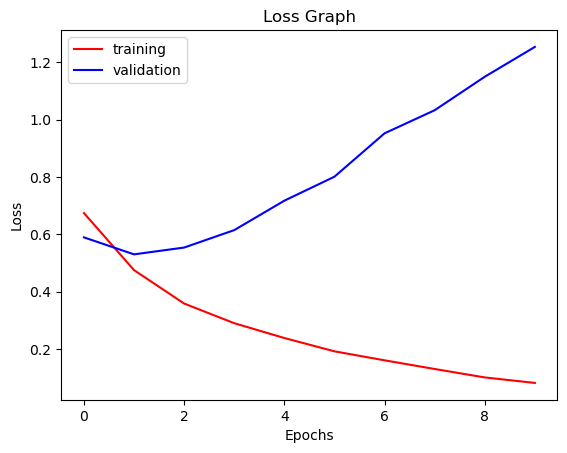

In [24]:
plt.plot(hist_data3.history['loss'], 'r', label='training')
plt.plot(hist_data3.history['val_loss'], 'b', label='validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Model 4: CNNs

Hyperparameters

In [25]:
EMBED_DIM = 16
FILTER_SIZE = (3,)
NUM_FILTERS = 32
DENSE_NEURONS = 8
EPOCHS = 10
BATCH_SIZE = 256

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalAveragePooling1D

model4 = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM, input_length=SNTNC_LEN),
    Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),

    GlobalAveragePooling1D(),
    Dense(DENSE_NEURONS, activation='relu'),
    Dense(1, activation='sigmoid')
])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 16)            262144    
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            1568      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263985 (1.01 MB)
Trainable params: 263985 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [27]:
model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [28]:
hist_data4 = model4.fit(
    train_pad_seqs, 
    training_labels, 
    validation_data=(val_pad_seqs, validation_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE
)

Epoch 1/10


98/98 [==============================] - 1s 4ms/step - loss: 0.6775 - accuracy: 0.5939 - val_loss: 0.6306 - val_accuracy: 0.6860
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.5191 - accuracy: 0.7635 - val_loss: 0.5328 - val_accuracy: 0.7286
Epoch 3/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3984 - accuracy: 0.8246 - val_loss: 0.5537 - val_accuracy: 0.7270
Epoch 4/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3418 - accuracy: 0.8556 - val_loss: 0.5932 - val_accuracy: 0.7226
Epoch 5/10
98/98 [==============================] - 0s 4ms/step - loss: 0.3033 - accuracy: 0.8752 - val_loss: 0.6431 - val_accuracy: 0.7163
Epoch 6/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2743 - accuracy: 0.8900 - val_loss: 0.6992 - val_accuracy: 0.7089
Epoch 7/10
98/98 [==============================] - 0s 4ms/step - loss: 0.2503 - accuracy: 0.9030 - val_loss: 0.7621 - val_accuracy: 0.7014
Epoch 8/10
98/98 [=============

### Plotting metrics

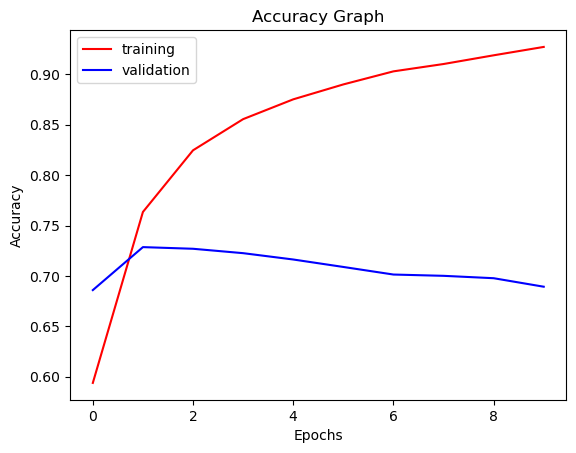

In [29]:
plt.plot(hist_data4.history['accuracy'], 'r', label='training')
plt.plot(hist_data4.history['val_accuracy'], 'b', label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

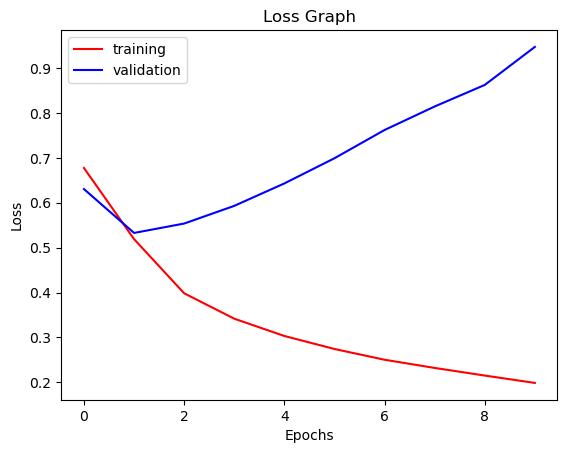

In [30]:
plt.plot(hist_data4.history['loss'], 'r', label='training')
plt.plot(hist_data4.history['val_loss'], 'b', label='validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss Graph')
plt.legend()
plt.show()

For less epochs, 